In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import functions as pfunc
from pyspark.sql import SQLContext
from pyspark.sql import Window, types

sc = pyspark.SparkContext(appName="phishingURL-AUTOML-V3-BestModel-Discovery")
sqlContext = SQLContext(sc)

import h2o
from h2o.automl import H2OAutoML

import subprocess
subprocess.run('unset http_proxy', shell=True)

h2o.init(ip="localhost",port=54321)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_172"; Java(TM) SE Runtime Environment (build 1.8.0_172-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.172-b11, mixed mode)
  Starting server from /opt/cloudera/parcels/Anaconda-5.1.0.1/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpmsa0vkmj
  JVM stdout: /tmp/tmpmsa0vkmj/h2o_siemanalyst_started_from_python.out
  JVM stderr: /tmp/tmpmsa0vkmj/h2o_siemanalyst_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ----------------------------------------
H2O cluster uptime:         01 secs
H2O cluster timezone:       UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.0.1
H2O cluster version age:    24 days
H2O cluster name:           H2O_from_python_siemanalyst_arh8ma
H2O cluster total nodes:    1
H2O cluster free memory:    5.176 Gb
H2O cluster total cores:    12
H2O cluster allowed cores:  12
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.4 final
--------------------------  ----------------------------------------

In [2]:
#!/usr/bin/env python
import string
import hashlib
import sys
import re
import numpy as np
from scipy import stats
"""
# -----------------------------------------------------------------------------
# this is the hive entry point:
# parameters are accepted as a tab delimited stream
# the stream must be read and broken
# variables will be assigned to the 'parameters' passed
# as a reference
# PARAMETERS EXPEXTED:
#
# -----------------------------------------------------------------------------
# 
"""
# -----------------------------------------------------------------------------
#
#  GOOD WORDS LIST
# list_values2 = "dazn.com.livesport.atlassian.net.performgroup.com.confluence.performgroup.com.google.co.uk.google.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.www.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
# list_values2 += "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
#
# BAD WORDS LIST
# list_values2 = "27media.ro.urlvalidation.com.amatorskihokej.pl.gilbertargentina.com.arcoinhive.com.track.o7go.com.cdntc.advancedmactuner.com.apple.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.com.webmine.cz.park.above.com.track.amishbrand.com.epiphany-walpole.org.track.o7go.com.picturesetc.net.epiphany-walpole.org.park.above.com.load.jsecoin.com.mail.cometgroup-eg.com.mail.arenacorporativo.com.hydra.edos.cl.mail.cometgroup-eg.com.mail.cometgroup-eg.com.santoshdiesel.com.mail.sumtexa.com.errors.newdatastatsserv.com/mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.com.junpiterfutbol.com.errors.newdatastatsserv.com/mac-error.gif.coin-services.info.errors.newdatastatsserv.com/newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"   
# list_values2 += "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
#
#
# BAD DOMAINS LIST
# list_values3 = "27media.urlvalidation.amatorskihokej.gilbertargentina.arcoinhive.track.o7go.cdntc.advancedmactuner.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.webmine.park.above.track.amishbrand.epiphany-walpole.track.o7go.picturesetc.epiphany-walpole.park.above.jsecoin.cometgroup-eg.arenacorporativo.hydra.edos.cl.mail.cometgroup-eg.cometgroup-eg.santoshdiesel.sumtexa.errors.newdatastatsserv.mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.junpiterfutbol.errors.newdatastatsserv.mac-error.gif.coin-services.info.errors.newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"
#
#
# -----------------------------------------------------------------------------
## URL size function1.
def func_url_lengh(var1):
    return len(var1)
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
### Every URL with More than 80 chars, will be massive .
## URL isbig=1/0 function2.
def func_url_big(var1):
    if (len(var1) > 80):
        return 1
    else:
        return 0
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## URL number of '@' chars function3.
def func_url_count_at(var1):
    return var1.count('@')
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## URL punctuation count function4.
def func_url_count_dot(var1):
    return var1.count('.')
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## URL isipyn=1/0 function5.
## Search if matches pattern : "http://xx.xx.xx.xx/anythingnonspace7662u.wkjw3932"
def func_url_is_ip(var1):
    cleanvar=var1.strip('http://').strip('https://')
    m1 = re.search('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))',cleanvar)
    m2 = re.search('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))([/]+)',cleanvar)
    m3 = re.search('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))([/]+)([\S]+)',cleanvar)
   
    if (m1 or m2 or m3):
        return 1
    else:
        return 0    
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------   
## URL count(".com") function7.
def func_count_dot_com(var1):
    return var1.count(".com") #overlapping
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------    
## URL KL from URL TO English Language function6.
def func_kl_en_url(var1):
    def KL(P,Q):
        epsilon = 0.00001
        P = P+epsilon
        Q = Q+epsilon
        divergence = np.sum(P*np.log(P/Q))
        return np.asscalar(divergence)
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.livesport.atlassian.net.performgroup.com.confluence.performgroup.com.google.co.uk.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.www.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    list_values2 += "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    ## Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    return KL(values1,values2)
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## URL "Kolmogorov-Smirnov test KS pvalue= ks_2samp function8.
def func_ks_en_url(var1):
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    values1= np.sort(values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.livesport.atlassian.net.performgroup.com.confluence.performgroup.com.google.co.uk.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.www.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    #list_values2 = "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    # Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2=np.asarray(list_of_ord_values2)
    values2=np.sort(values2)
    (Darray,pvalue)=stats.ks_2samp(values1, values2)
    return np.asscalar(pvalue)
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## BAD URL Y/N from KL from URL TO English Language function9.
def func_bad_kl_en_url(var1):
    def KL(P,Q):
        epsilon = 0.00001
        P = P+epsilon
        Q = Q+epsilon
        divergence = np.sum(P*np.log(P/Q))
        return np.asscalar(divergence)
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.livesport.atlassian.net.performgroup.com.confluence.performgroup.com.google.co.uk.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.www.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    list_values2 += "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    ## Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2=np.asarray(list_of_ord_values2)
    kl_value=KL(values1,values2)
    if kl_value < 0.0:
        return 1
    elif kl_value >= 100.01:
        return 1
    else:
        return 0
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## BAD URL Y/N "Kolmogorov-Smirnov test KS pvalue= ks_2samp function10.
def func_bad_ks_en_url(var1):
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    values1= np.sort(values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.livesport.atlassian.net.performgroup.com.confluence.performgroup.com.google.co.uk.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.www.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    #list_values2 = "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    #Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    values2 = np.sort(values2)
    (Darray,pvalue)=stats.ks_2samp(values1, values2)
    scalar_pvalue=np.asscalar(pvalue)
    if scalar_pvalue >=0.5:
        return 0
    else:
        return 1
#
# -----------------------------------------------------------------------------    
## URL KL from URL TO English Language function11.
def func_kl_phish_url(var1):
    def KL(P,Q):
        epsilon = 0.00001
        P = P+epsilon
        Q = Q+epsilon
        divergence = np.sum(P*np.log(P/Q))
        return np.asscalar(divergence)
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common Malware/phishing sites used in internal webtraffic
    list_values2 = "27media.ro.urlvalidation.com.amatorskihokej.pl.gilbertargentina.com.arcoinhive.com.track.o7go.com.cdntc.advancedmactuner.com.apple.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.com.webmine.cz.park.above.com.track.amishbrand.com.epiphany-walpole.org.track.o7go.com.picturesetc.net.epiphany-walpole.org.park.above.com.load.jsecoin.com.mail.cometgroup-eg.com.mail.arenacorporativo.com.hydra.edos.cl.mail.cometgroup-eg.com.mail.cometgroup-eg.com.santoshdiesel.com.mail.sumtexa.com.errors.newdatastatsserv.com/mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.com.junpiterfutbol.com.errors.newdatastatsserv.com/mac-error.gif.coin-services.info.errors.newdatastatsserv.com/newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"   
    #
    ## Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    return KL(values1,values2)
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## URL "Kolmogorov-Smirnov test KS pvalue= ks_2samp function12.
def func_ks_phish_url(var1):
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    values1= np.sort(values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common Malware/phishing sites used in internal webtraffic
    list_values2 = "27media.ro.urlvalidation.com.amatorskihokej.pl.gilbertargentina.com.arcoinhive.com.track.o7go.com.cdntc.advancedmactuner.com.apple.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.com.webmine.cz.park.above.com.track.amishbrand.com.epiphany-walpole.org.track.o7go.com.picturesetc.net.epiphany-walpole.org.park.above.com.load.jsecoin.com.mail.cometgroup-eg.com.mail.arenacorporativo.com.hydra.edos.cl.mail.cometgroup-eg.com.mail.cometgroup-eg.com.santoshdiesel.com.mail.sumtexa.com.errors.newdatastatsserv.com/mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.com.junpiterfutbol.com.errors.newdatastatsserv.com/mac-error.gif.coin-services.info.errors.newdatastatsserv.com/newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"
    #
    ## Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2=np.asarray(list_of_ord_values2)
    values2=np.sort(values2)
    (Darray,pvalue)=stats.ks_2samp(values1, values2)
    return np.asscalar(pvalue)
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## BAD URL Y/N from KL from URL TO English Language function13.
def func_bad_kl_phish_url(var1):
    def KL(P,Q):
        epsilon = 0.00001
        P = P+epsilon
        Q = Q+epsilon
        divergence = np.sum(P*np.log(P/Q))
        return np.asscalar(divergence)
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common Malware/phishing sites used in internal webtraffic
    list_values2 = "27media.ro.urlvalidation.com.amatorskihokej.pl.gilbertargentina.com.arcoinhive.com.track.o7go.com.cdntc.advancedmactuner.com.apple.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.com.webmine.cz.park.above.com.track.amishbrand.com.epiphany-walpole.org.track.o7go.com.picturesetc.net.epiphany-walpole.org.park.above.com.load.jsecoin.com.mail.cometgroup-eg.com.mail.arenacorporativo.com.hydra.edos.cl.mail.cometgroup-eg.com.mail.cometgroup-eg.com.santoshdiesel.com.mail.sumtexa.com.errors.newdatastatsserv.com/mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.com.junpiterfutbol.com.errors.newdatastatsserv.com/mac-error.gif.coin-services.info.errors.newdatastatsserv.com/newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"
    #
    ## Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2=np.asarray(list_of_ord_values2)
    kl_value=KL(values1,values2)
    if kl_value < 0.0:
        return 1
    elif kl_value >= 100.01:
        return 1
    else:
        return 0
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## BAD URL Y/N "Kolmogorov-Smirnov test KS pvalue= ks_2samp function14.
def func_bad_ks_phish_url(var1):
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    values1= np.sort(values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common Malware/phishing sites used in internal webtraffic
    list_values2 = "27media.ro.urlvalidation.com.amatorskihokej.pl.gilbertargentina.com.arcoinhive.com.track.o7go.com.cdntc.advancedmactuner.com.apple.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.com.webmine.cz.park.above.com.track.amishbrand.com.epiphany-walpole.org.track.o7go.com.picturesetc.net.epiphany-walpole.org.park.above.com.load.jsecoin.com.mail.cometgroup-eg.com.mail.arenacorporativo.com.hydra.edos.cl.mail.cometgroup-eg.com.mail.cometgroup-eg.com.santoshdiesel.com.mail.sumtexa.com.errors.newdatastatsserv.com/mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.com.junpiterfutbol.com.errors.newdatastatsserv.com/mac-error.gif.coin-services.info.errors.newdatastatsserv.com/newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"
    #
    ##Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    values2 = np.sort(values2)
    (Darray,pvalue)=stats.ks_2samp(values1, values2)
    scalar_pvalue=np.asscalar(pvalue)
    if scalar_pvalue >=0.5:
        return 0
    else:
        return 1
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## BAD words in URL based in our Internal Phishing function15.
def func_bad_words_domain(var1):
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common Malware/phishing sites used in internal webtraffic
    list_values3 = "27media.urlvalidation.amatorskihokej.gilbertargentina.arcoinhive.track.o7go.cdntc.advancedmactuner.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.webmine.park.above.track.amishbrand.epiphany-walpole.track.o7go.picturesetc.epiphany-walpole.park.above.jsecoin.cometgroup-eg.arenacorporativo.hydra.edos.cl.mail.cometgroup-eg.cometgroup-eg.santoshdiesel.sumtexa.errors.newdatastatsserv.mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.junpiterfutbol.errors.newdatastatsserv.mac-error.gif.coin-services.info.errors.newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"
    #
    ##Making sure the analysis ignore web domain and focus on typical pyshing/malware site names.
    to_clear=cleanvar.split(".")[0]+"."
    #print("to_clear="+to_clear)
    if list_values3.find(to_clear) == -1:
        return 0
    else:
        return 1
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
while True:
    line = sys.stdin.readline()
    if not line:
        break
    line = string.strip(line, "\n ")
    clienturls = string.split(line, "\t")
    clienturl = clienturls[0]
    url_lengh=func_url_lengh(clienturl)
    massiveurl=func_url_big(clienturl)
    count_at=func_url_count_at(clienturl)
    count_dot=func_url_count_dot(clienturl)
    url_is_ip=func_url_is_ip(clienturl)
    url_kl_en=func_kl_en_url(clienturl)
    count_dot_com=func_count_dot_com(clienturl)
    url_ks_en=func_ks_en_url(clienturl)
    print ("\t".join([ url_lengh, massiveurl, count_at, count_dot, url_is_ip, url_kl_en, count_dot_com,url_ks_en ]))
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------    
# TEST FUNCTIONS5
print("F5")
print(func_url_is_ip("www.google.com"))
print(func_url_is_ip("35.190.74.53"))
#
# TEST FUNCTIONS7
print("F7")
print(func_kl_en_url("www.google.com"))
print(func_kl_en_url("www.10.112.41.21.com/bug.html"))
print(func_kl_en_url("www.tciauto.com/js/prototype/prototype.js"))
# TEST FUNCTIONS9
print("F9")
print(func_bad_kl_en_url("www.google.com"))
print(func_bad_kl_en_url("www.10.112.41.21.com/bug.html"))
print(func_bad_kl_en_url("www.tciauto.com/js/prototype/prototype.js"))
# TEST FUNCTIONS8
print("F8")
print(func_ks_en_url("www.google.com"))
print(func_ks_en_url("www.10.112.41.21.com/bug.html"))
print(func_ks_en_url("www.tciauto.com/js/prototype/prototype.js"))
# TEST FUNCTIONS10
print("F10")
print(func_bad_ks_en_url("www.google.com"))
print(func_bad_ks_en_url("www.10.112.41.21.com/bug.html"))
print(func_bad_ks_en_url("www.tciauto.com/js/prototype/prototype.js"))
#
# TEST FUNCTIONS11
print("F11")
print(func_kl_phish_url("www.google.com"))
print(func_kl_phish_url("www.10.112.41.21.com/bug.html"))
print(func_kl_phish_url("www.tciauto.com/js/prototype/prototype.js"))
# TEST FUNCTIONS13
print("F13")
print(func_bad_kl_phish_url("www.google.com"))
print(func_bad_kl_phish_url("www.10.112.41.21.com/bug.html"))
print(func_bad_kl_phish_url("www.tciauto.com/js/prototype/prototype.js"))
# TEST FUNCTIONS12
print("F12")
print(func_ks_phish_url("www.google.com"))
print(func_ks_phish_url("www.10.112.41.21.com/bug.html"))
print(func_ks_phish_url("www.tciauto.com/js/prototype/prototype.js"))
# TEST FUNCTIONS14
print("F14")
print(func_bad_ks_phish_url("www.google.com"))
print(func_bad_ks_phish_url("www.10.112.41.21.com/bug.html"))
print(func_bad_ks_phish_url("www.tciauto.com/js/prototype/prototype.js"))
# TEST FUNCTIONS15
print("F15")
print(func_bad_words_domain("www.google.com"))
print(func_bad_words_domain("www.10.112.41.21.com/bug.html"))
print(func_bad_words_domain("www.tciauto.com/js/prototype/prototype.js"))
#

F5
0
1
F7
0.0
-328.04527262467434
370.01622984524306
F9
0
1
1
F8
1.0
0.010363878041822367
0.29749496918785295
F10
0
1
1
F11
197.42956955516755
-316.0192293834367
368.7343343532466
F13
1
1
1
F12
0.6750781537165951
0.010363878041822386
0.1023725717454872
F14
0
1
1
F15
0
1
1


In [ ]:
import re
import pandas as pd
import numpy as np
from pandas import DataFrame
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.sql.functions import *
from scipy.stats import kstest
from scipy import stats
#
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## URL size function1.
def func_url_lengh(var1):
    return len(var1)
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
### Every URL with More than 80 chars, will be massive .
## URL isbig=1/0 function2.
def func_url_big(var1):
    if (len(var1) > 80):
        return 1
    else:
        return 0
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## URL number of '@' chars function3.
def func_url_count_at(var1):
    return var1.count('@')
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## URL punctuation count function4.
def func_url_count_dot(var1):
    return var1.count('.')
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## URL isipyn=1/0 function5.
## Search if matches pattern : "http://xx.xx.xx.xx/anythingnonspace7662u.wkjw3932"
def func_url_is_ip(var1):
    cleanvar=var1.strip('http://').strip('https://')
    m1 = re.search('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))',cleanvar)
    m2 = re.search('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))([/]+)',cleanvar)
    m3 = re.search('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))([/]+)([\S]+)',cleanvar)
   
    if (m1 or m2 or m3):
        return 1
    else:
        return 0    
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------   
## URL count(".com") function7.
def func_count_dot_com(var1):
    return var1.count(".com") #overlapping
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------    
## URL KL from URL TO English Language function6.
def func_kl_en_url(var1):
    def KL(P,Q):
        epsilon = 0.00001
        P = P+epsilon
        Q = Q+epsilon
        divergence = np.sum(P*np.log(P/Q))
        return np.asscalar(divergence)
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.livesport.atlassian.net.performgroup.com.confluence.performgroup.com.google.co.uk.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.www.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    list_values2 += "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    ## Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    return KL(values1,values2)
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## URL "Kolmogorov-Smirnov test KS pvalue= ks_2samp function8.
def func_ks_en_url(var1):
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    values1= np.sort(values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.livesport.atlassian.net.performgroup.com.confluence.performgroup.com.google.co.uk.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.www.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    #list_values2 = "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    # Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2=np.asarray(list_of_ord_values2)
    values2=np.sort(values2)
    (Darray,pvalue)=stats.ks_2samp(values1, values2)
    return np.asscalar(pvalue)
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## BAD URL Y/N from KL from URL TO English Language function9.
def func_bad_kl_en_url(var1):
    def KL(P,Q):
        epsilon = 0.00001
        P = P+epsilon
        Q = Q+epsilon
        divergence = np.sum(P*np.log(P/Q))
        return np.asscalar(divergence)
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.livesport.atlassian.net.performgroup.com.confluence.performgroup.com.google.co.uk.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.www.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    list_values2 += "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    ## Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2=np.asarray(list_of_ord_values2)
    kl_value=KL(values1,values2)
    if kl_value < 0.0:
        return 1
    elif kl_value >= 100.01:
        return 1
    else:
        return 0
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## BAD URL Y/N "Kolmogorov-Smirnov test KS pvalue= ks_2samp function10.
def func_bad_ks_en_url(var1):
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    values1= np.sort(values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common non-Malware/phishing sites used in internal webtraffic
    list_values2 = "google.com.dazn.com.livesport.atlassian.net.performgroup.com.confluence.performgroup.com.google.co.uk.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.www.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    #list_values2 = "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    #Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    values2 = np.sort(values2)
    (Darray,pvalue)=stats.ks_2samp(values1, values2)
    scalar_pvalue=np.asscalar(pvalue)
    if scalar_pvalue >=0.5:
        return 0
    else:
        return 1
#
# -----------------------------------------------------------------------------    
## URL KL from URL TO English Language function11.
def func_kl_phish_url(var1):
    def KL(P,Q):
        epsilon = 0.00001
        P = P+epsilon
        Q = Q+epsilon
        divergence = np.sum(P*np.log(P/Q))
        return np.asscalar(divergence)
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common Malware/phishing sites used in internal webtraffic
    list_values2 = "27media.ro.urlvalidation.com.amatorskihokej.pl.gilbertargentina.com.arcoinhive.com.track.o7go.com.cdntc.advancedmactuner.com.apple.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.com.webmine.cz.park.above.com.track.amishbrand.com.epiphany-walpole.org.track.o7go.com.picturesetc.net.epiphany-walpole.org.park.above.com.load.jsecoin.com.mail.cometgroup-eg.com.mail.arenacorporativo.com.hydra.edos.cl.mail.cometgroup-eg.com.mail.cometgroup-eg.com.santoshdiesel.com.mail.sumtexa.com.errors.newdatastatsserv.com/mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.com.junpiterfutbol.com.errors.newdatastatsserv.com/mac-error.gif.coin-services.info.errors.newdatastatsserv.com/newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"   
    list_values2 += "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    #
    ## Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    return KL(values1,values2)
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## URL "Kolmogorov-Smirnov test KS pvalue= ks_2samp function12.
def func_ks_phish_url(var1):
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    values1= np.sort(values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common Malware/phishing sites used in internal webtraffic
    list_values2 = "27media.ro.urlvalidation.com.amatorskihokej.pl.gilbertargentina.com.arcoinhive.com.track.o7go.com.cdntc.advancedmactuner.com.apple.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.com.webmine.cz.park.above.com.track.amishbrand.com.epiphany-walpole.org.track.o7go.com.picturesetc.net.epiphany-walpole.org.park.above.com.load.jsecoin.com.mail.cometgroup-eg.com.mail.arenacorporativo.com.hydra.edos.cl.mail.cometgroup-eg.com.mail.cometgroup-eg.com.santoshdiesel.com.mail.sumtexa.com.errors.newdatastatsserv.com/mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.com.junpiterfutbol.com.errors.newdatastatsserv.com/mac-error.gif.coin-services.info.errors.newdatastatsserv.com/newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"
    #
    ## Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2=np.asarray(list_of_ord_values2)
    values2=np.sort(values2)
    (Darray,pvalue)=stats.ks_2samp(values1, values2)
    return np.asscalar(pvalue)
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## BAD URL Y/N from KL from URL TO English Language function13.
def func_bad_kl_phish_url(var1):
    def KL(P,Q):
        epsilon = 0.00001
        P = P+epsilon
        Q = Q+epsilon
        divergence = np.sum(P*np.log(P/Q))
        return np.asscalar(divergence)
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common Malware/phishing sites used in internal webtraffic
    list_values2 = "27media.ro.urlvalidation.com.amatorskihokej.pl.gilbertargentina.com.arcoinhive.com.track.o7go.com.cdntc.advancedmactuner.com.apple.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.com.webmine.cz.park.above.com.track.amishbrand.com.epiphany-walpole.org.track.o7go.com.picturesetc.net.epiphany-walpole.org.park.above.com.load.jsecoin.com.mail.cometgroup-eg.com.mail.arenacorporativo.com.hydra.edos.cl.mail.cometgroup-eg.com.mail.cometgroup-eg.com.santoshdiesel.com.mail.sumtexa.com.errors.newdatastatsserv.com/mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.com.junpiterfutbol.com.errors.newdatastatsserv.com/mac-error.gif.coin-services.info.errors.newdatastatsserv.com/newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"
    list_values2 += "google.com.dazn.com.performgroup.com.goal.com.bitly.com.goo.gl.amazon.com.office.com.gmail.com.apple.com.trivago.com.expedia.com.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.www.google.com.amazon.apple.trivago.expedia.hotels.andcastles.andhouseboats.andigloos.andteepees.andriversidecabins.andlakesidecabins.andpondsidecabins.andstreamadjacentcabins.andcabinsthatarentnearanybodiesofwaterwhatsoever.andlakehouses.andregularhousesandlodgesandskilodgesandallthings.ski/ChaletRelatedAndBoutiquesAnd5StarSuitesAndRetreatsAndBungalowsAndJungleBungalowsAndOtherKindaLessExcitingBungalowsAndCabanasAndOceansideCabanasAndSeaSideCabanasWhichSeemLikeTheSameThingAndBedAndBreakfastsAndJustBedsBecauseThoseAreKindOfARequirementInRoomsOfAnyKindInOurOpinionAndCottagesAndVacationHomesAndHostelsAndYouCanGetRewardedBasicallyEverywhereAndResortsAndGetawaysAndInnsAndHarborInnsAndVillasForGuysNamedJamieFromNorthEasternMiamiAndVillasForHumansNamedAnyOtherKindOfHumanNameAndTreehousesAndHousesNearTreesAndRanchesForPeopleWhoReallyLikeFarmAnimalsAndRanchesForPeopleWhoJustFeelKindOfSoSoAboutFarmAnimalsAndRanchesInGeneralAndCliffHousesAndRewardsAndYesWeAreSurprisedYouAreStillTypingAtThisPointButHeyWeStillHaveMoreAccomodationsSoWeWillJustKeepListingThemBroBroAndBeachGetawaysAndSnowyGetawaysAndThoseAreTheOnlyTwoKindsOfGetawaysAndMansionsAndLoftsAndFarmStaysAndFarmStayRetreatsSpecificallyInNewZealandBecauseNothingSaysLuxuryLikeAnExcessOfHayAndGoatNoisesAndIceHotelsAndIceCabinsAndIceLodgesAndHotelsWithBalconyCapabilitiesAndHotelsWithRooftopsBecauseEveryHotelNeedsARoofItIsKindOfJustLogisticalAndTimesharesAndCountryHomesAndPalazzinasAndYesWeKnowWhatPalazzinasAreDontActLikeWeDontWhoIsTheExpertHereAndPenthousesAndManorsAndStatelyManorsWhichFeelPrettySimilarAndTownhousesAndPalacesAndHousesAndCasasWhichAreHousesButInSpanishAndGuestHousesForWomenNamedTammyWhoLiveForAGreatDealAndRewardsForEveryoneElseWhoLikesAGreatDealAndAllTypesOfPlacesForPetsAndAllTypesOfPlacesForNotPetsAndThemedHotelsAndPirateHotelsAndFairyTaleHotelsAndHauntedHotelsAndHauntedMotelsOrToPutItAnotherWayMotelsAndYesWeAreStillGoingAndFamilyResortsAndPlacesNearGoatYogaAndPlacesWherePeopleHaveMusclesAndPlacesThatServeMelonBetweenTheHoursOf6And10AMAnd.HouseYachtsAndYachtClubsAndOtherThingsOnOrNearWaterAndDolphinMotelsInLowerSanDiegoAndAlsoYurts.com.www.1.2.3.4.5.6.7.8.9.0.llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch.co.uk"
    ## Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2=np.asarray(list_of_ord_values2)
    kl_value=KL(values1,values2)
    if kl_value < 0.0:
        return 1
    elif kl_value >= 100.01:
        return 1
    else:
        return 0
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## BAD URL Y/N "Kolmogorov-Smirnov test KS pvalue= ks_2samp function14.
def func_bad_ks_phish_url(var1):
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    len_var1=len(cleanvar)
    idx_var1=cleanvar[:8]
    list_values1 = list(cleanvar)
    list_of_ord_values1 = [ord(char) for char in list_values1]
    values1 = np.asarray(list_of_ord_values1)
    values1= np.sort(values1)
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common Malware/phishing sites used in internal webtraffic
    list_values2 = "27media.ro.urlvalidation.com.amatorskihokej.pl.gilbertargentina.com.arcoinhive.com.track.o7go.com.cdntc.advancedmactuner.com.apple.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.com.webmine.cz.park.above.com.track.amishbrand.com.epiphany-walpole.org.track.o7go.com.picturesetc.net.epiphany-walpole.org.park.above.com.load.jsecoin.com.mail.cometgroup-eg.com.mail.arenacorporativo.com.hydra.edos.cl.mail.cometgroup-eg.com.mail.cometgroup-eg.com.santoshdiesel.com.mail.sumtexa.com.errors.newdatastatsserv.com/mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.com.junpiterfutbol.com.errors.newdatastatsserv.com/mac-error.gif.coin-services.info.errors.newdatastatsserv.com/newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"
    #
    ##Making sure the analysis start on the same webdomain name
    idx_var2 = list_values2.find(idx_var1)
    start_values2=list_values2[:idx_var2]
    list_values2 = list(start_values2+list_values2)
    list_of_ord_values2 = [ord(char) for char in list_values2]
    list_of_ord_values2 =list_of_ord_values2[:len_var1]
    values2 = np.asarray(list_of_ord_values2)
    values2 = np.sort(values2)
    (Darray,pvalue)=stats.ks_2samp(values1, values2)
    scalar_pvalue=np.asscalar(pvalue)
    if scalar_pvalue >=0.5:
        return 0
    else:
        return 1
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## BAD words in URL based in our Internal Phishing function15.
def func_bad_words_domain(var1):
    cleanvar=var1.strip('http://').strip('https://').strip('www.')
    # URLS with at least 4166 characters
    ## TODO : Complete this list with common Malware/phishing sites used in internal webtraffic
    list_values3 = "27media.urlvalidation.amatorskihokej.gilbertargentina.arcoinhive.track.o7go.cdntc.advancedmactuner.com-repairing-macbook.live.bestofpantac58.club.anastasiabeauties.com.ssl.icel-analytics.webmine.park.above.track.amishbrand.epiphany-walpole.track.o7go.picturesetc.epiphany-walpole.park.above.jsecoin.cometgroup-eg.arenacorporativo.hydra.edos.cl.mail.cometgroup-eg.cometgroup-eg.santoshdiesel.sumtexa.errors.newdatastatsserv.mac-error.gif.check4free.goodthewaysystemcontents.club.goodwaysystemforlinks.icu.ephzhb.ba.jshosting.bid.junpiterfutbol.junpiterfutbol.errors.newdatastatsserv.mac-error.gif.coin-services.info.errors.newdatastatsserv.mac-error.gif.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy.lh4.googleusercontent.com/proxy.junpiterfutbol.com/wp-content/uploads.junpiterfutbol.com/wp-content/themes/magazinevibe.junpiterfutbol.com/wp-includes/js/mediaelement.junpiterfutbol.com/wp-content/plugins.lh4.googleusercontent.com/proxy.lh3.googleusercontent.com/proxy/Kio4wI3UK3zZzRs.lh3.googleusercontent.com/proxy/m6VPEbuhm1bUutlLMXrO0IG9laOxq-.lh3.googleusercontent.com/proxy/WsQX20fScfePa3ywk8TItAbHri0WIJg27chYNFm09rbddhntflFDd5PlwFGLbcQ-bojUBBGDLHBusy08cjL7m6J_.trackcmp.net/visit.trackcmp.net/redir.bttrack.com/pixel/cookiesync.dbrsupportportal.dellbackupandrecovery.com.errors.newdatastatsserv.com/mac-error.gif.sc.iasds01.com/dtc.mrfinancechallenge.com.lh4.googleusercontent.com/proxy/l6PVvv0DTBegtdzFoqZW48oOKdK6Ogiz-.mrfinancechallenge.com.park.above.com.query.network.lh5.googleusercontent.com/proxy/3bKkRRVFT75mOCZKFTno0pyp3zjRU5Gssm3xK.webacc12.sd5.ghst.net.webacc12.sd5.ghst.net.apps4612.srvrize7.live.girrjaqgjb.com.webmine.cz.amatorskihokej.pl.junpiterfutbol.com/wp-includes.lh4.googleusercontent.com/proxy/VwiFM4ubjgiJxpWl3TtlqXfogV5h8GbEfioNr3Y.lh4.googleusercontent.com/proxy/HAwE2myEwEP3w9ApAURprguN6biMao1jllCLQ.lh4.googleusercontent.com/proxy/yvj5Z3VZ5xl8Xe6ecO4D.lh6.googleusercontent.com/proxy/FGgHhIQmg8P.tciauto.com.tci.track.o7go.com.personaly.click.ws003.coinhive.com.apc994.com.c.smxindia.in.glyphsjmuyt.xyz.c.o5o4o6.com.ttegjzxzxyetf.com.zambiafootballshop.com.worldnaturenet.xyz.apc994.com.tech-beats.com.c.o5o4o6.com.filanwuatuese.ml.jshosting.win.filanwuatuese.ml.fmtrendgames.com.estoyonline.cl.xr0.specialrewards16.com.voice-mailportalmanagement.ufaharigirlsministries.co.ug.competition8006.ttiprize75.life.mybestaskflash.icu.c.smxindia.in.urlvalidation.com.c.o5o4o6.com.cdntc.advancedmactuner.com.cdntc.advancedmactuner.com.examhome.net.learningtoolkit.club.o12zs3u2n.com.8b0b17dc1f9f8010.com.c.traktum.com.competition2699.ttiprize21.life.apple.com-fast-macbook.live.coffeetrials.in.net.wzdzht7am5.com.urlvalidation.com.qamopo.com.27media.ro.personaly.click.net.madgicomedia.club.c.traktum.com.anastasiabeauties.com.stretfordendflags.com.coinhive.com.coin-hive.com.bournfavor.club.ttegjzxzxyetf.com.c.o5o4o6.com.minergate.com.goodandmainlystablelinkslast.icu.8b0b17dc1f9f8010.com.alwaysup.thecentersitetodownloadcontentfree.icu.c.px9y36.com.apc994.com.cashbeet.com.pitchinforbaseball.org.murrychristmas.in.net.competition2212.pmrprize35.live.cpdbalochistan.org.c.px9y36.com"
    #
    ##Making sure the analysis ignore web domain and focus on typical pyshing/malware site names.
    to_clear=cleanvar.split(".")[0]+"."
    #print("to_clear="+to_clear)
    if list_values3.find(to_clear) == -1:
        return 0
    else:
        return 1
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# # BUG      : https://issues.apache.org/jira/browse/SPARK-12157
# # Solution : https://stackoverflow.com/questions/9452775/converting-numpy-dtypes-to-native-python-types/11389998
#
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------    
#
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
## Transformation DI ynverified=1/0 FROM yes/no
def func_url_verified(var1):
    if var1==None:
        return 1
    if ( var1.lower()=='yes'):
        return 1
    elif (var1.lower()=='no'):
        return 0
    else :
        return 1
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------    
## Languages eng ynverified=0 else =1
def func_url_lang_en_ynverified(var1):
    # https://commoncrawl.github.io/cc-crawl-statistics/plots/languages
    catalogue_valid_langs = ("eng","rus","jpn","deu","fra","zho","spa","por","ita","pol","nld","ces","tur","vie","ind","swe",\
                       "ara","fas","kor","ron","hun","ell","dan","ukr","fin","tha","nor","bul","slk","cat","heb","srp",\
                       "hrv","lit","msa","est","slv","lav","hin","ben","aze","lat","isl","tam","sqi","bos","kat","hye",\
                       "glg","urd","eus","mkd","kaz","mal","nno","mon","bel","nep","uzb","tel","mya","tgl","afr","mar",\
                       "swa","cym","kan","sin","guj","khm","tat","som","epo","kur","gle","kir","pan","fao","oci","tgk",\
                       "pus","amh","fry","ltz","mlg","war","lao","mlt","kin","ori","san","hau","gla","bre","cos","roh",\
                       "bak","hat","jav","yid","bod","ceb","grn","uig","sco","tuk","blu","div","ina","kal","tir","bih",\
                       "mri","nya","snd","sun","vol","asm","zul","glv","ile","orm","que","smo","sna","syr","xho","yor",\
                       "aar","abk","haw","ibo","kha","lin","sot","iku","lug","nso","run","tsn")
    catalogue_invalid_langs = ("<unknown>","unknown","<other>","other")
    if var1==None:
        return 1
    elif (var1.lower().startswith(catalogue_valid_langs)):
        return 1
    elif (var1.lower().startswith(catalogue_invalid_langs)):
        return 0
    else:
        return 0
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
#
# UDF Functional DI Converstions 
func_url_verified_udf = udf(func_url_verified, IntegerType())
func_url_lang_en_ynverified_udf = udf(func_url_lang_en_ynverified, IntegerType())
# UDF COEFICIENT FUNCTIONS : [1-11] 
func_url_lengh_udf = udf(func_url_lengh, IntegerType())
func_url_big_udf = udf(func_url_big, IntegerType())
func_url_count_at_udf = udf(func_url_count_at, IntegerType())
func_url_count_dot_udf = udf(func_url_count_dot, IntegerType())
func_url_is_ip_udf = udf(func_url_is_ip, IntegerType())
func_count_dot_com_udf = udf(func_count_dot_com, IntegerType())
func_kl_en_url_udf = udf(func_kl_en_url, FloatType())
func_ks_en_url_udf = udf(func_ks_en_url, FloatType())
func_bad_kl_en_url_udf = udf(func_bad_kl_en_url, IntegerType())
func_bad_ks_en_url_udf = udf(func_bad_ks_en_url, IntegerType())
func_kl_phish_url_udf = udf(func_kl_phish_url, IntegerType())
func_ks_phish_url_udf = udf(func_ks_phish_url, IntegerType())
func_bad_kl_phish_url_udf = udf(func_bad_kl_phish_url, IntegerType())
func_bad_ks_phish_url_udf = udf(func_bad_ks_phish_url, IntegerType())
func_bad_words_domain_udf = udf(func_bad_words_domain, IntegerType())
#
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------    
#
## Get all URL Commom Crawl from
## List of Top Level Domains : *.com *.org *.co.uk *.ru *.net *.cn *.cz *.kp *.us "
# 
ccrawl_traindf = sqlContext.read.json("hdfs:///user/siemanalyst/data/raw/commoncrawl/dt=20181112/clean-CC-MAIN-2018-43-index-.*.json")
ccrawl_traindf.printSchema()
#
#### MODEL1
#.withColumn('ynverified',lit(0).cast('int') )\
#### MODEL 2
#.withColumn('ynverified',func_url_lang_en_ynverified_udf(ccrawl_traindf['languages']).cast('int') )\

## Assume URLS as not phishing ynverified=0 if EN as phishing ynverified=1
ccrawl_trainds = ccrawl_traindf\
.withColumn('ynverified',lit(0).cast('int') )\
.withColumn('url_length',func_url_lengh_udf(ccrawl_traindf['url']).cast('int'))\
.withColumn('massiveurl',func_url_big_udf(ccrawl_traindf['url']).cast('int'))\
.withColumn('count_at',func_url_count_at_udf(ccrawl_traindf['url']).cast('int'))\
.withColumn('count_dot',func_url_count_dot_udf(ccrawl_traindf['url']).cast('int'))\
.withColumn('url_is_ip',func_url_is_ip_udf(ccrawl_traindf['url']).cast('int'))\
.withColumn('count_dot_com',func_count_dot_com_udf(ccrawl_traindf['url']).cast('int'))\
.withColumn('url_kl_en',func_kl_en_url_udf(ccrawl_traindf['url']).cast('double'))\
.withColumn('url_bad_kl_en',func_bad_kl_en_url_udf(ccrawl_traindf['url']).cast('int'))\
.withColumn('url_ks_en',func_ks_en_url_udf(ccrawl_traindf['url']).cast('double'))\
.withColumn('url_bad_ks_en',func_bad_ks_en_url_udf(ccrawl_traindf['url']).cast('int'))\
.withColumn('url_kl_phish',func_kl_phish_url_udf(ccrawl_traindf['url']).cast('double'))\
.withColumn('url_bad_kl_phish',func_bad_kl_phish_url_udf(ccrawl_traindf['url']).cast('int'))\
.withColumn('url_ks_phish',func_ks_phish_url_udf(ccrawl_traindf['url']).cast('double'))\
.withColumn('url_bad_ks_phish',func_bad_ks_phish_url_udf(ccrawl_traindf['url']).cast('int'))\
.withColumn('url_bad_words_domain',func_bad_words_domain_udf(ccrawl_traindf['url']).cast('int'))\
.drop('charset','digest','filename','verification_time','languages','length','mime','mime-detected','offset','status')
#

ccrawl_trainds.printSchema()
ccrawl_persist=ccrawl_trainds.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
#
### From Phishtank Import Malware urls
#phishtank_trainpd=pd.read_csv("/home/siemanalyst/notebooks/siem/verified_online.csv")
#phishtank_trainds=phishtank_trainpd.drop(columns=['phish_id','phish_detail_url','submission_time','verification_time','online','target'])
#phishtank_trainds['url_length'] = phishtank_trainds['url'].map(str).apply(len)
#phishtank_trainds['massiveurl'] = np.where(phishtank_trainds['url_length'] > 80 , 1, 0)
#phishtank_trainds.head(6)
#phishtank_train=h2o.H2OFrame(phishtank_trainds)
#
#phishtank_testpd=pd.read_csv("/home/siemanalyst/notebooks/siem/verified_online.csv")
#phishtank_testds=phishtank_testpd.drop(columns=['phish_id','phish_detail_url','submission_time','verification_time','online','target'])
#phishtank_testds['url_length'] = phishtank_testds['url'].map(str).apply(len)
#phishtank_testds['massiveurl'] = np.where(phishtank_testds['url_length'] > 80 , 1, 0)
#phishtank_testds.head(6)
#phishtank_test=h2o.H2OFrame(phishtank_testds.head(1000))
#
phishtank_traindf= sqlContext.read.json("hdfs:///user/siemanalyst/data/raw/phishtank/dt=20181112/*.json")
phishtank_traindf.printSchema()

phishtank_trainds=phishtank_traindf\
.withColumn('ynverified',func_url_verified_udf(phishtank_traindf['verified']).cast('int'))\
.withColumn('url_length',func_url_lengh_udf(phishtank_traindf['url']).cast('int'))\
.withColumn('massiveurl',func_url_big_udf(phishtank_traindf['url']).cast('int'))\
.withColumn('count_at',func_url_count_at_udf(phishtank_traindf['url']).cast('int'))\
.withColumn('count_dot',func_url_count_dot_udf(phishtank_traindf['url']).cast('int'))\
.withColumn('url_is_ip',func_url_is_ip_udf(phishtank_traindf['url']).cast('int'))\
.withColumn('count_dot_com',func_count_dot_com_udf(phishtank_traindf['url']).cast('int'))\
.withColumn('url_kl_en',func_kl_en_url_udf(phishtank_traindf['url']).cast('double'))\
.withColumn('url_bad_kl_en',func_bad_kl_en_url_udf(phishtank_traindf['url']).cast('int'))\
.withColumn('url_ks_en',func_ks_en_url_udf(phishtank_traindf['url']).cast('double'))\
.withColumn('url_bad_ks_en',func_bad_ks_en_url_udf(phishtank_traindf['url']).cast('int'))\
.withColumn('url_kl_phish',func_kl_phish_url_udf(phishtank_traindf['url']).cast('double'))\
.withColumn('url_bad_kl_phish',func_bad_kl_phish_url_udf(phishtank_traindf['url']).cast('int'))\
.withColumn('url_ks_phish',func_ks_phish_url_udf(phishtank_traindf['url']).cast('int'))\
.withColumn('url_bad_ks_phish',func_bad_ks_phish_url_udf(phishtank_traindf['url']).cast('double'))\
.withColumn('url_bad_words_domain',func_bad_words_domain_udf(phishtank_traindf['url']).cast('int'))\
.drop('details','online','phish_detail_url','phish_id','submission_time','target','verification_time','verified')
phishtank_trainds.printSchema()
#
# Join with Internal Curation Data
#phish_malw_dfile=sqlContext.\
#read.json("hdfs:///user/siemanalyst/data/staged/urltopredict/dt=20181116/*.json")
#phish_malw_dfile.printSchema()
#
#internal_phishing_malware_df=phish_malw_dfile.\
#select('url',phish_malw_dfile.ynverified.cast('int'),\
#       phish_malw_dfile.url_length.cast('int'),phish_malw_dfile.massiveurl.cast('int'),\
#       phish_malw_dfile.count_at.cast('int'),phish_malw_dfile.count_dot.cast('int'),\
#       phish_malw_dfile.url_is_ip.cast('int'),phish_malw_dfile.count_dot_com.cast('int'),\
#       phish_malw_dfile.url_kl_en.cast('double'),phish_malw_dfile.url_bad_kl_en.cast('int'),\
#       phish_malw_dfile.url_ks_en.cast('double'),phish_malw_dfile.url_bad_ks_en.cast('int'))\
#.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
#internal_phishing_malware_df.printSchema()
#
phishtank_persist=phishtank_trainds.persist(pyspark.StorageLevel.MEMORY_AND_DISK_2)
#phishtank_persist=phishtank_trainds.union(internal_phishing_malware_df).\ ERROR Type conflict Pandas
#phishtank_persist.printSchema()
#
#intern_phish_mal_pd=internal_phishing_malware_df.toPandas()
#intern_phish_mal_hf=h2o.H2OFrame(intern_phish_mal_pd)
#
ccrawl_train_pd=ccrawl_persist.toPandas()  
ccrawl_test_pd=ccrawl_persist.toPandas().head(8000)
ccrawl_train_hf=h2o.H2OFrame(ccrawl_train_pd)
ccrawl_test_hf=h2o.H2OFrame(ccrawl_test_pd)
#
# H2OContext not possible to complex to serialize
#ccrawl_train_hf = hc.as_h2o_frame(ccrawl_persist)
#ccrawl_test_hf= hc.as_h2o_frame(ccrawl_persist.head(8000))
#
phishtank_train_pd=phishtank_persist.toPandas()  
phishtank_test_pd=phishtank_persist.toPandas().head(8000)
phishtank_train=h2o.H2OFrame(phishtank_train_pd)
phishtank_test=h2o.H2OFrame(phishtank_test_pd)
#
#
###### TRAINING PROCESS ############
# RBIND "Merge" all of 3 internal ccrawl and phishtank with rbind .
# function merge() doesn't work if both H2O/dataframes have same variables
#
train = ccrawl_train_hf.rbind(phishtank_train)
test = ccrawl_test_hf.rbind(phishtank_test)

#train = intern_phish_mal_hf.rbind(ccrawl_train_hf).rbind(phishtank_train)
#test = ccrawl_test_hf.rbind(phishtank_test)
'''
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
---------------------------------------------------------------------------
H2OValueError                             Traceback (most recent call last)
<ipython-input-7-d61a356c7500> in <module>()
    276 # function merge() doesn't work if both H2O/dataframes have same variables
    277 #
--> 278 train = intern_phish_mal_hf.rbind(ccrawl_train_hf).rbind(phishtank_train)
    279 test = ccrawl_test_hf.rbind(phishtank_test)
    280 

/opt/cloudera/parcels/Anaconda-5.1.0.1/lib/python3.6/site-packages/h2o/frame.py in rbind(self, data)
   1745                                     "the columns must match" % (frame.ncol, self.ncol))
   1746             if frame.columns != self.columns or frame.types != self.types:
-> 1747                 raise H2OValueError("Column names and types must match for rbind() to work")
   1748         fr = H2OFrame._expr(expr=ExprNode("rbind", self, *frames), cache=self._ex._cache)
   1749         fr._ex._cache.nrows = self.nrow + sum(frame.nrow for frame in frames)

H2OValueError: Column names and types must match for rbind() to work

root
 |-- url: string (nullable = true)
 |-- ynverified: integer (nullable = false)
 |-- url_length: integer (nullable = true)
 |-- massiveurl: integer (nullable = true)
 |-- count_at: integer (nullable = true)
 |-- count_dot: integer (nullable = true)
 |-- url_is_ip: integer (nullable = true)
 |-- count_dot_com: integer (nullable = true)
 |-- url_kl_en: double (nullable = true)
 |-- url_bad_kl_en: integer (nullable = true)
 |-- url_ks_en: double (nullable = true)
 |-- url_bad_ks_en: integer (nullable = true)

    
root
 |-- url: string (nullable = true)
 |-- ynverified: integer (nullable = true)
 |-- url_length: integer (nullable = true)
 |-- massiveurl: integer (nullable = true)
 |-- count_at: integer (nullable = true)
 |-- count_dot: integer (nullable = true)
 |-- url_is_ip: integer (nullable = true)
 |-- count_dot_com: integer (nullable = true)
 |-- url_kl_en: double (nullable = true)
 |-- url_bad_kl_en: integer (nullable = true)
 |-- url_ks_en: double (nullable = true)
 |-- url_bad_ks_en: integer (nullable = true)  
'''

# Identify predictors and response
x = train.columns

# test Learning is it a bit URL TRUE/FALSE
#y = 'massiveurl'

# Casual is it verified phishing from url characteristics TRUE/FALSE
y= 'ynverified'
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 40 base models (limited to 1 hour max runtime by default)

aml = H2OAutoML(max_models=20, seed=1999)
aml.train(x=x, y=y, training_frame=train)


root
 |-- charset: string (nullable = true)
 |-- digest: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- languages: string (nullable = true)
 |-- length: string (nullable = true)
 |-- mime: string (nullable = true)
 |-- mime-detected: string (nullable = true)
 |-- offset: string (nullable = true)
 |-- status: string (nullable = true)
 |-- url: string (nullable = true)

root
 |-- url: string (nullable = true)
 |-- ynverified: integer (nullable = false)
 |-- url_length: integer (nullable = true)
 |-- massiveurl: integer (nullable = true)
 |-- count_at: integer (nullable = true)
 |-- count_dot: integer (nullable = true)
 |-- url_is_ip: integer (nullable = true)
 |-- count_dot_com: integer (nullable = true)
 |-- url_kl_en: double (nullable = true)
 |-- url_bad_kl_en: integer (nullable = true)
 |-- url_ks_en: double (nullable = true)
 |-- url_bad_ks_en: integer (nullable = true)
 |-- url_kl_phish: double (nullable = true)
 |-- url_bad_kl_phish: integer (nullable = true

In [4]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

This H2OFrame is empty.


In [7]:
# The leader model is stored here
aml.leader
# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

#preds = aml.predict(test)
# or:
#preds = aml.leader.predict(test)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20181116_233709
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.031958937759404116
RMSE: 0.17877062890588072
LogLoss: 0.12553793083638867
Null degrees of freedom: 119508
Residual degrees of freedom: 119499
Null deviance: 109390.37901942583
Residual deviance: 30005.825152651945
AIC: 30025.825152651945
AUC: 0.9914812259369427
pr_auc: 0.9679264876330013
Gini: 0.9829624518738853
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6125224358142036: 


0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      18183  2268   0.1109   (2268.0/20451.0)
1      2491   96567  0.0251   (2491.0/99058.0)
Total  20674  98835  0.0398   (4759.0/119509.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.612522     0.975952  181
max f2                       0.345826     0.982644  265
max f0point5                 0.805287     0.983518  118
max accuracy                 0.612522     0.960179  181
max precision                0.978643     1         0
max recall                   0.100586     1         361
max specificity              0.978643     1         0
max absolute_mcc             0.659647     0.862225  167
max min_per_class_accuracy   0.75173      0.954134  138
max mean_per_class_accuracy  0.824091     0.958468  111

Gains/Lift Table: Avg response rate: 82.89 %, avg score: 82.32 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100076                   0.978653           1.20645    1.20645            1                0.978871  1                           0.978871            0.0120737       0.0120737                  20.6455   20.6455
    2        0.0200069                   0.978529           1.20645    1.20645            1                0.978585  1                           0.978728            0.0120636       0.0241374                  20.6455   20.6455
    3        0.0300061                   0.978367           1.20645    1.20645            1                0.978466  1                           0.978641            0.0120636       0.036201                   20.6455   20.6455
    4        0.0400054                   0.978103           1.20645    1.20645            1                0.978247  1                           0.978543            0.0120636       0.0482647                  20.6455   20.6455
    5        0.0500046                   0.977844           1.20645    1.20645            1                0.977992  1                           0.978432            0.0120636       0.0603283                  20.6455   20.6455
    6        0.100001                    0.976767           1.20645    1.20645            1                0.977098  1                           0.977765            0.0603182       0.120646                   20.6455   20.6455
    7        0.150005                    0.976125           1.20645    1.20645            1                0.97651   1                           0.977347            0.0603283       0.180975                   20.6455   20.6455
    8        0.200002                    0.975358           1.20645    1.20645            1                0.975699  1                           0.976935            0.0603182       0.241293                   20.6455   20.6455
    9        0.300003                    0.972851           1.20645    1.20645            1                0.974193  1                           0.976021            0.120646        0.361939                   20.6455   20.6455
    10       0.400003                    0.970415           1.20645    1.20645            1                0.971661  1                           0.974931            0.120646        0.482586                   20.6455   20.6455
    11       0.500004                    0.965491           1.20645    1.20645            1                0.968343  1                           0.973613            0.120646        0.603232                   20.6455   20.6455
    12       0.599997                    0.955509           1.20645    1.20645            1                0.961235  1                           0.97155             0.120636        0.723869                   20.6455   20.6455
    13       0.699997                    0.927188           1.20565    1.20634            0.999331         0.943992  0.999904                    0.967613            0.120566        0.844435                   20.5647   20.6339
    14       0.799998                    0.746623           1.11025    1.19433            0.920258         0.868626  0.989948                    0.95524             0.111026        0.95546                    11.0249   19.4328
    15       0.899999                    0.238705           0.422779   1.1086             0.350431         0.483971  0.91889                     0.902876            0.0422783       0.997739                   -57.7221  10.86
    16       1                           0.0128802          0.0226128  1                  0.0187432        0.106215  0.828875                    0



ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.07636806312889083
RMSE: 0.276347721410709
LogLoss: 0.252649049959426
Null degrees of freedom: 13346
Residual degrees of freedom: 13337
Null deviance: 12393.607137848969
Residual deviance: 6744.213739616918
AIC: 6764.213739616918
AUC: 0.9320995419387351
pr_auc: 0.9741358476437811
Gini: 0.8641990838774702
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4505084441564122: 


0     1      Error    Rate
-----  ----  -----  -------  ----------------
0      1372  968    0.4137   (968.0/2340.0)
1      439   10568  0.0399   (439.0/11007.0)
Total  1811  11536  0.1054   (1407.0/13347.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450508     0.937586  253
max f2                       0.119034     0.965683  361
max f0point5                 0.85505      0.942477  110
max accuracy                 0.532502     0.895257  229
max precision                0.978886     1         0
max recall                   0.0134748    1         399
max specificity              0.978886     1         0
max absolute_mcc             0.687269     0.633148  178
max min_per_class_accuracy   0.879478     0.856818  98
max mean_per_class_accuracy  0.898588     0.859623  86

Gains/Lift Table: Avg response rate: 82.47 %, avg score: 82.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100397                   0.978631           1.21259   1.21259            1                0.978865  1                           0.978865            0.0121741       0.0121741                  21.2592   21.2592
    2        0.0200045                   0.978527           1.21259   1.21259            1                0.978576  1                           0.978721            0.0120832       0.0242573                  21.2592   21.2592
    3        0.0300442                   0.978366           1.21259   1.21259            1                0.978466  1                           0.978636            0.0121741       0.0364314                  21.2592   21.2592
    4        0.040009                    0.978092           1.21259   1.21259            1                0.97823   1                           0.978535            0.0120832       0.0485146                  21.2592   21.2592
    5        0.0500487                   0.977701           1.21259   1.21259            1                0.977949  1                           0.978417            0.0121741       0.0606887                  21.2592   21.2592
    6        0.100022                    0.976755           1.20714   1.20987            0.995502         0.977062  0.997753                    0.97774             0.0603252       0.121014                   20.7138   20.9867
    7        0.149996                    0.976028           1.20896   1.20956            0.997001         0.976453  0.997502                    0.977311            0.0604161       0.18143                    20.8956   20.9564
    8        0.200045                    0.975156           1.21078   1.20987            0.998503         0.975554  0.997753                    0.976872            0.0605978       0.242028                   21.0777   20.9867
    9        0.299993                    0.9724             1.20441   1.20805            0.993253         0.973815  0.996254                    0.975853            0.120378        0.362406                   20.4411   20.8049
    10       0.400015                    0.96967            1.20169   1.20646            0.991011         0.971163  0.994943                    0.97468             0.120196        0.482602                   20.1692   20.646
    11       0.500037                    0.963026           1.19715   1.2046             0.987266         0.96685   0.993407                    0.973114            0.119742        0.602344                   19.7151   20.4598
    12       0.599985                    0.948013           1.15442   1.19624            0.952024         0.956814  0.986513                    0.970399            0.115381        0.717725                   15.4417   19.6238
    13       0.700007                    0.906425           1.07725   1.17924            0.88839          0.930921  0.972493                    0.964758            0.10775         0.825475                   7.7254    17.9237
    14       0.799955                    0.723665           0.906263  1.14513            0.747376         0.840468  0.944366                    0.949229            0.0905787       0.916053                   -9.37375  14.5131
    15       0.899978                    0.289154           0.614017  1.0861             0.506367         0.512565  0.895688                    0.900699            0.0614155       0.977469                   -38.5983  8.61037
    16       1                           0.0128906          0.225261  1                  0.185768         0.127869  0.82468                     0.823398          



ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.07439584718380778
RMSE: 0.27275602135206434
LogLoss: 0.24570537758089062
Null degrees of freedom: 119508
Residual degrees of freedom: 119498
Null deviance: 109390.99954505332
Residual deviance: 58728.007938629315
AIC: 58750.007938629315
AUC: 0.935437318785046
pr_auc: 0.9699789049289781
Gini: 0.870874637570092
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4560751029482874: 


0      1       Error    Rate
-----  -----  ------  -------  ------------------
0      11804  8647    0.4228   (8647.0/20451.0)
1      3814   95244   0.0385   (3814.0/99058.0)
Total  15618  103891  0.1043   (12461.0/119509.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.456075     0.9386    248
max f2                       0.0996546    0.966247  366
max f0point5                 0.857891     0.944718  106
max accuracy                 0.531813     0.896552  223
max precision                0.978917     1         0
max recall                   0.0129045    1         399
max specificity              0.978917     1         0
max absolute_mcc             0.747925     0.635623  151
max min_per_class_accuracy   0.879763     0.8599    95
max mean_per_class_accuracy  0.898701     0.862746  84

Gains/Lift Table: Avg response rate: 82.89 %, avg score: 82.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100076                   0.978751           1.20645   1.20645            1                0.979036  1                           0.979036            0.0120737       0.0120737                  20.6455   20.6455
    2        0.0200069                   0.978453           1.20645   1.20645            1                0.978593  1                           0.978815            0.0120636       0.0241374                  20.6455   20.6455
    3        0.0300061                   0.978247           1.20545   1.20612            0.999163         0.978349  0.999721                    0.978659            0.0120535       0.0361909                  20.5445   20.6118
    4        0.0400054                   0.978028           1.20645   1.2062             1                0.978146  0.999791                    0.978531            0.0120636       0.0482546                  20.6455   20.6202
    5        0.0500046                   0.977699           1.20545   1.20605            0.999163         0.977871  0.999665                    0.978399            0.0120535       0.0603081                  20.5445   20.6051
    6        0.100001                    0.976598           1.20484   1.20545            0.998661         0.977044  0.999163                    0.977722            0.0602374       0.120546                   20.4839   20.5445
    7        0.150005                    0.975949           1.20565   1.20551            0.999331         0.976276  0.999219                    0.97724             0.0602879       0.180833                   20.5647   20.5513
    8        0.200002                    0.97524            1.20444   1.20524            0.998326         0.975604  0.998996                    0.976831            0.0602172       0.241051                   20.4436   20.5243
    9        0.300003                    0.973085           1.20211   1.2042             0.996402         0.974252  0.998131                    0.975971            0.120212        0.361263                   20.2114   20.42
    10       0.400003                    0.969973           1.19838   1.20274            0.993306         0.971604  0.996925                    0.974879            0.119839        0.481102                   19.8379   20.2745
    11       0.500004                    0.963883           1.18697   1.19959            0.983851         0.96745   0.99431                     0.973393            0.118698        0.5998                     18.6971   19.959
    12       0.599997                    0.949993           1.15335   1.19188            0.955983         0.957987  0.987923                    0.970826            0.115326        0.715126                   15.3351   19.1884
    13       0.699997                    0.911129           1.08592   1.17675            0.900092         0.934338  0.975375                    0.965613            0.108593        0.823719                   8.59204   17.6746
    14       0.799998                    0.749399           0.917334  1.14432            0.760355         0.850705  0.948497                    0.95125             0.0917341       0.915454                   -8.26663  14.4319
    15       0.899999                    0.312473           0.615796  1.08559            0.510418         0.541324  0.899821                    0.905702            0.0615801       0.977034                   -38.4204  8.5594
    16       1                           0.0120029          0.229662  1                  0.190361         0.1374    0.828875                    0.828871            0

In [8]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(aml.leader.metalearner()['name'])
metalearner.coef_norm()

{'DRF_1_AutoML_20181116_233709': 0.9569200851008385,
 'DeepLearning_1_AutoML_20181116_233709': 0.06680928558296692,
 'DeepLearning_grid_1_AutoML_20181116_233709_model_1': 0.019057451120001102,
 'DeepLearning_grid_1_AutoML_20181116_233709_model_2': 0.03280303166508434,
 'GBM_1_AutoML_20181116_233709': 0.0,
 'GBM_2_AutoML_20181116_233709': 0.0,
 'GBM_3_AutoML_20181116_233709': 0.0,
 'GBM_4_AutoML_20181116_233709': 0.0,
 'GBM_5_AutoML_20181116_233709': 0.0,
 'GBM_grid_1_AutoML_20181116_233709_model_1': 6.415549080524265e-06,
 'GBM_grid_1_AutoML_20181116_233709_model_2': 0.0,
 'GLM_grid_1_AutoML_20181116_233709_model_1': 0.10286323836816316,
 'Intercept': 2.3671772059048415,
 'XGBoost_1_AutoML_20181116_233709': 0.1811688055520251,
 'XGBoost_2_AutoML_20181116_233709': 0.0,
 'XGBoost_3_AutoML_20181116_233709': 0.0,
 'XGBoost_grid_1_AutoML_20181116_233709_model_1': 0.0,
 'XGBoost_grid_1_AutoML_20181116_233709_model_2': 0.0,
 'XGBoost_grid_1_AutoML_20181116_233709_model_3': 0.0,
 'XGBoost_grid

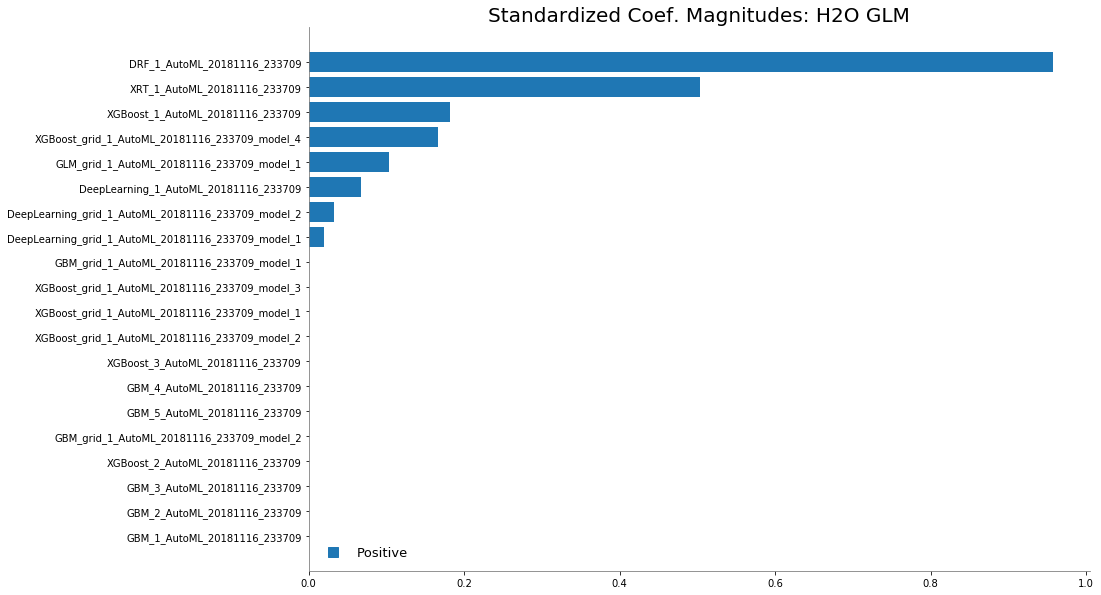

In [9]:
%matplotlib inline
metalearner.std_coef_plot()

In [10]:
aml.leader.download_mojo(path = "./product_model_bin/m20/v3/mojo", get_genmodel_jar = True)

'/home/siemanalyst/notebooks/siem/product_model_bin/m20/v2/mojo/StackedEnsemble_AllModels_AutoML_20181116_233709.zip'

In [9]:
sc.stop()